In [ ]:
import os
import time
from random import shuffle
from random import random
from copy import deepcopy
import numpy as np
import collections
import pandas
from PIL import Image

In [ ]:
directory_main = os.getcwd()
ndvi_path = directory_main + "/sample_data/dataset/ndvi/"
output_path = directory_main + "/sample_data/output/"
dataset_path = directory_main + "/sample_data/dataset/MergedData.csv"
ALGORITHM_NAME = "RL - Value Iteration"

MAX_VEG_TYPE = 8
MAX_FIRE = 2
MAX_WS = 3
MAX_WD = 8
MAX_TEMP = 4

states_range = {}

states_range['veg_type_range'] = range(0, MAX_VEG_TYPE)
states_range['fire_range'] = range(0, MAX_FIRE)
states_range['ws_range'] = range(0, MAX_WS)
states_range['wd_range'] = range(0, MAX_WD)
states_range['temp_range'] = range(0, MAX_TEMP)

actions = [(-1,0),
           (1,0), 
           (0,1),  
           (0,-1),
           (-1,-1), #NW
          (1,-1), #SW
          (-1,1), #NE
          (1,1), #SE
          (0,0)]

PROB_FAILURE = 0.20
PROB_SUCCESS = 1 - PROB_FAILURE
GAMMA = 0.9
LEARNING_RATE = 0.25
ERROR_THRES = 0.001

NO_TRAINING_ITERATIONS = 10

MAX_STEPS = 500
NO_OF_TRIALS = 10
FRAME_TIME = 0.3
MAX_TRAIN_ITER = 10000000
TRAIN_ITER_LENGTH = 10
reward = 0
dataset_col_list = ['row', 'col','latitude', 'longitude',
                    'fire_nofire', 'category','wind_speed','wind_direction',
                    'temperature', 'filename']

START = [0, 0]
MAX_ROWS = 16
MAX_COLS = 16
GOAL = (0, 3)
environment = []
IMAGES=[]
CLASSES=[]

path = (directory_main)
os.chdir(path)
os.getcwd()

'/content'

In [ ]:
def transform_veg(x):
        x = x.lower()
        if x == 'grasslands, vernal pools, meadows, and other herb communities':
            return 0
        elif x == 'scrub and chaparral':
            return 1
        elif x == 'disturbed or developed areas':
            return 2
        elif x == 'water':
            return 3
        elif x == 'woodland':
            return 4
        elif x == 'forest':
            return 5
        elif x == 'dune community':
            return 6
        elif x == 'riparian and bottomland habitat':
            return 7

In [ ]:
def transform_wind_speed(x):
        if x >= 0 and x <= 12:
            return 0
        elif x > 12 and x <= 24:
            return 1
        else:
            return 2

In [ ]:
def transform_wind_direction(x):
        if x == 'N':
            return 0
        elif x == 'S':
            return 1
        elif x == 'E':
            return 2
        elif x == 'W':
            return 3
        elif x == 'NW':
            return 4
        elif x == 'SW':
            return 5
        elif x == 'NE':
            return 6
        else:
            #SE
            return 7

In [ ]:
def transform_temperature(x):
        if x >= 0 and x <= 32:
            #low
            return 0
        elif x > 32 and x <= 70:
            #average
            return 1
        elif x > 70 and x <= 90:
            #high
            return 2
        else:
            #dangerously high
            return 3

In [ ]:
def generate_transformation_data(pandas_df):
  
    pandas_df['category'] = pandas_df['category'].apply(transform_veg)

    pandas_df['fire_nofire'] = pandas_df['fire_nofire'].apply(lambda x: 0 if x.lower() == 'no fire' else 1)
    
    pandas_df['wind_speed'] = pandas_df['wind_speed'].apply(transform_wind_speed)

    pandas_df['wind_direction'] = pandas_df['wind_direction'].apply(transform_wind_direction)

    pandas_df['temperature'] = pandas_df['temperature'].apply(transform_temperature)
    
    return pandas_df

In [ ]:
def read_environment(filename):

    df = pandas.read_csv(filename, header=0, nrows=256, names=dataset_col_list)
    modified_df = generate_transformation_data(df)
    for index, rows in modified_df.iterrows(): 
        
        my_list = [
            int(rows.row), int(rows.col), rows.latitude, rows.longitude, int(rows.fire_nofire), 
            int(rows.category), int(rows.wind_speed), int(rows.wind_direction), int(rows.temperature), 
            (rows.filename)
        ]
                  
        environment.append(my_list)
        
        IMAGES.append(np.asarray(Image.open(os.path.join(ndvi_path, rows.filename)).resize((28, 28))))
        CLASSES.append(int(rows.fire_nofire))
        
    return environment
environment = read_environment(dataset_path)

In [ ]:
# helper to decode veg type into a numerical value
def get_decode_veg_type(val):
    if val == -1:
        return 'Fire'
    if val == 0:
        return 'Grasslands, vernal pools, meadows, and other herb communities'
    elif val == 1: 
        return 'Scrub and chaparral'
    elif val == 2:
        return 'Disturbed or developed areas'
    elif val == 3:
        return 'Water'
    elif val == 4:
        return 'Woodland'
    elif val == 5:
        return 'Forest'
    elif val == 6:
        return 'Dune community'
    elif val == 7:
        return 'Riparian and bottomland habitat'



In [ ]:
pip install image_slicer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import image_slicer

image_slicer.slice(os.path.join(ndvi_path, "Fire_shapefile.jpeg"), MAX_ROWS * MAX_COLS)

IMAGES = []

for row in range(0, MAX_ROWS):
  for col in range(0, MAX_COLS):
    IMAGES.append(np.asarray(Image.open(os.path.join(ndvi_path, ("Fire_shapefile" + "_" + str(row + 1).zfill(2) + "_" + str(col + 1).zfill(2) + ".png"))).resize((28, 28))))


In [ ]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib import colors
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image

def create_grid_fig(environment, fire_position, index):
    rows = MAX_ROWS
    cols = MAX_COLS
    
    fig = plt.figure(figsize=(8, 8))
    grid = ImageGrid(
        fig,
        111,
        nrows_ncols=(rows, cols),  
        axes_pad=0.0,
        cbar_mode='edge'
    )
    
    for ax, im, c in zip(grid, IMAGES, CLASSES):

      ax.imshow(im, cmap='terrain', aspect='auto')

      if c == 1:
          extent = 0, 100, 0, 100
          kwargs = {"alpha":0.5}
          circle = patches.Circle((15, 15), radius=5, linewidth=2, edgecolor='r', facecolor='r', **kwargs)
          ax.add_patch(circle)
    plt.show()
    fig.savefig(output_path + 'output_learning_' + str(index) + '.png', bbox_inches='tight')

def create_map(index, environment, fire_position = [0,0]):
    global CLASSES
    flat_idx = MAX_COLS * fire_position[0] + fire_position[1]
    CLASSES[flat_idx] = 1
    create_grid_fig(environment, fire_position,index)
    
def clear():
    os.system( 'cls' )

In [ ]:
def get_set_start_position(environment):
    starting_states = []
 
    for x,row in enumerate(environment):
        if environment[x][4] == 1:
            starting_states += [(environment[x][0], environment[x][1], 
                                 environment[x][4], environment[x][5], 
                                 environment[x][6], environment[x][7], environment[x][8])]
 
    shuffle(starting_states)
    global START
    START = starting_states[0]
    return starting_states[0]

In [ ]:
starting_state = get_set_start_position(environment)

In [ ]:
START

(8, 7, 1, 5, 2, 6, 3)

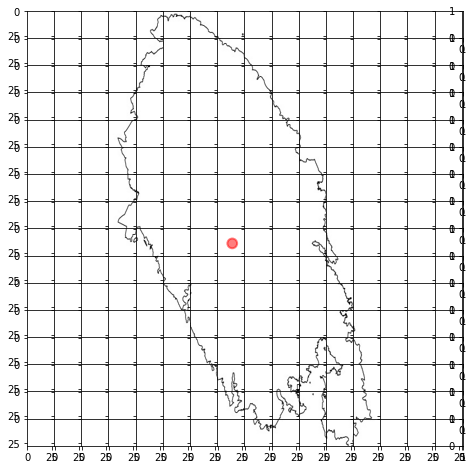

In [ ]:
create_map(00, environment, [START[0], START[1]])

In [ ]:
def get_wind_dir_coordinates(wind_dir):
    w_x = 0
    w_y = 0
    if wind_dir == 0:
        w_x = -1
        w_y = 0
    elif wind_dir == 1:
        w_x = 1
        w_y = 0
    elif wind_dir == 2:
        w_x = 0
        w_y = 1
    elif wind_dir == 3:
        w_x = 0
        w_y = -1
    elif wind_dir == 4:
        w_x = -1
        w_y = -1
    elif wind_dir == 5:
        w_x = 1
        w_y = -1
    elif wind_dir == 6:
        w_x = -1
        w_y = 1
    elif wind_dir == 7:
        w_x = 1
        w_y = 1
        
        
    return w_x, w_y

In [ ]:
def find_next_position(old_pos, action, environment):
    
    rows = MAX_ROWS
    cols = MAX_COLS
    
    x, y = old_pos[0], old_pos[1]
    
    new_x, new_y = x + action[0], y + action[1]
    flat_idx = cols * new_x + new_y
    if is_valid_bounds(new_x, new_y, rows, cols)  and environment[flat_idx][5] != 3:
        return new_x, new_y, environment[flat_idx][5],1, environment[flat_idx][6], environment[flat_idx][7], environment[flat_idx][8]

    return x, y, environment[x][5], 1, environment[x][6], environment[x][7], environment[x][8]

def is_valid_bounds(x, y, rows, cols):
    return x >= 0 and x < rows and y >= 0 and y < cols

In [ ]:
def get_nearest_open_cell(environment, x_initial, y_initial, open = [START, GOAL]):
    
    rows = int(len(environment) / MAX_ROWS)
    cols = len(environment) % MAX_COLS
    
    max_radius = max(rows,cols)
 
    for radius in range(max_radius):
        x_off_range = range(-radius, radius + 1)

    for x_offset in x_off_range:

        x = x_initial + x_offset
        y_radius = radius - abs(x_offset)
        y_range = range(y_initial - y_radius, y_initial + y_radius + 1)

        for y in y_range:
            if x < 0 or x >= rows: continue
            if y < 0 or y >= cols: continue

            return (x, y)  
    return

In [ ]:
def act(old_x, old_y, old_veg_type, old_fire, old_ws, old_wd, old_temp, action, environment, deterministic=(
    False)):
    rows = int(len(environment) / MAX_ROWS )
    cols = len(environment) % MAX_COLS
    
    if not deterministic:
 
        if random() > PROB_SUCCESS: 
            action = (0,0)
            
    new_x, new_y, new_veg_type, new_fire, new_ws, new_wd, new_temp = find_next_position((old_y,old_x), action,( 
                                     environment))
    
    
    if [new_x, new_y] != START and (new_x, new_y) != GOAL:
        return new_x, new_y, new_veg_type, new_fire, new_ws, new_wd, new_temp
    
    return old_x, old_y, old_veg_type, old_fire, old_ws, old_wd, old_temp
    
 

In [ ]:
def get_policy_from_Q(cols, rows, Q, actions):
    
    pi = {}
 
    for x in range(0, rows): 
        for y in range(0, cols): 
            for veg in states_range['veg_type_range']:
                for fire in states_range['fire_range']:
                    for ws in states_range['ws_range']:
                        for wd in states_range['wd_range']:
                            for temp in states_range['temp_range']:
                                pi[(x, y,veg,fire,ws,wd,temp)] = actions[np.argmax(Q[x][y][veg][fire][ws][wd][temp])]        
    return(pi)

In [ ]:
def value_iteration(environment, no_training_iter =( 
    NO_TRAINING_ITERATIONS), train_iter_length = TRAIN_ITER_LENGTH):
    
    rows = MAX_ROWS
    cols = MAX_COLS

    values = [[[[[[[random() for _ in states_range['temp_range']] for _ in states_range['wd_range']] 
             for _ in states_range['ws_range']] for _ in states_range['fire_range']] for _ in states_range['veg_type_range']] 
                for _ in range(0, cols)]
                    for _ in range(0, rows)]
    
    for x in range(0, rows): 
        for y in range(0, cols): 
            if (x,y) == GOAL:
                for veg in states_range['veg_type_range']:
                    for fire in states_range['fire_range']:
                        for ws in states_range['ws_range']:
                            for wd in states_range['wd_range']:
                                for temp in states_range['temp_range']:
                                        values[x][y][veg][fire][ws][wd][temp] = 1
                                        
    Q = [[[[[[[[random() for _ in actions] for _ in states_range['temp_range']] for _ in states_range['wd_range']] 
             for _ in states_range['ws_range']] for _ in states_range['fire_range']] for _ in states_range['veg_type_range']] 
                for _ in range(0, cols)]
                    for _ in range(0, rows)]
    
    for x in range(0, rows): 
        for y in range(0, cols): 
            if (x,y) == GOAL:
                for veg in states_range['veg_type_range']:
                    for fire in states_range['fire_range']:
                        for ws in states_range['ws_range']:
                            for wd in states_range['wd_range']:
                                for temp in states_range['temp_range']:
                                    for ai, a in enumerate(actions):
                                        Q[x][y][veg][fire][ws][wd][temp][ai] = 1
                                    

    for iter in range(no_training_iter):
        
        values_prev = deepcopy(values)
        delta = 0.0
        
        for x in range(0, rows): 
            for y in range(0, cols): 
                for veg in states_range['veg_type_range']:
                    for fire in states_range['fire_range']:
                        for ws in states_range['ws_range']:
                            for wd in states_range['wd_range']:
                                for temp in states_range['temp_range']:
                                    flat_idx = cols * x + y
                                    if environment[flat_idx][5] == 2 or environment[flat_idx][5] == 3 or environment[flat_idx][5] == 4 or environment[flat_idx][5] == 6:
                                        values[x][y][veg][fire][ws][wd][temp] = -9.9
                                        continue
                                    
                                    for ai, a in enumerate(actions):
                                        if (x, y) == GOAL: 
                                            break
                                            
                                        flat_idx = cols * x + y
                                        if environment[flat_idx][5] == 2 or environment[flat_idx][5] == 3 or environment[flat_idx][5] == 4 or environment[flat_idx][5] == 6:
                                            break
                                            
                                        r = 1.0

                                        new_x, new_y, new_veg_type, new_fire, new_ws, new_wd, new_temp = act(x, y, veg, fire,  ws, wd, temp,a, environment) 

                                        value_new_state = values_prev[new_x][new_y][new_veg_type][new_fire][new_ws][new_wd][new_temp]
 
                                        new_x, new_y, new_veg_type, new_fire, new_ws, new_wd, new_temp = act(x, y, veg, fire,  ws, wd, temp, (0, 0) , environment) 
                                        
                                        value_new_state_if_action_fails = values_prev[new_x][new_y][new_veg_type][new_fire][new_ws][new_wd][new_temp]
    
                                        expected_value = (  
                                            PROB_SUCCESS * value_new_state) + (
                                            PROB_FAILURE * (value_new_state_if_action_fails))
    
                                        Q[x][y][veg][fire][ws][wd][temp][ai] = r + ( GAMMA * expected_value )
                                        argMaxQ = np.argmax(Q[x][y][veg][fire][ws][wd][temp])
                                        
                                        values[x][y][veg][fire][ws][wd][temp] =  Q[x][y][veg][fire][ws][wd][temp][argMaxQ]
                                        
                            
                                        for x in range(0, rows): 
                                            for y in range(0, cols): 
                                                if (x,y) == GOAL:
                                                    for veg in states_range['veg_type_range']:
                                                        for fire in states_range['fire_range']:
                                                            for ws in states_range['ws_range']:
                                                                for wd in states_range['wd_range']:
                                                                    for temp in states_range['temp_range']:
                                                                         values[x][y][veg][fire][ws][wd][temp] = 1
        
                                        delta = max([max([max([max([max([max([max([abs( values[x][y][veg][fire][ws][wd][temp] - values_prev[new_x][new_y][new_veg_type][new_fire][new_ws][new_wd][new_temp]) 
                                                       for _ in states_range['temp_range']]) 
                                                          for _ in states_range['wd_range']]) 
                                                             for _ in states_range['ws_range']]) 
                                                                for _ in states_range['fire_range']]) 
                                                                   for _ in states_range['veg_type_range']]) 
                                                                      for _ in range(0, cols)])
                                                                        for _ in range(0, rows)])
        
                                        if delta < ERROR_THRES:
                                            return(get_policy_from_Q(cols, rows, Q, actions))
    
    
    return(get_policy_from_Q(cols, rows, Q, actions))

In [ ]:
def evaluate_model_analysis(environment, policy, animate = False, 
                  max_steps = MAX_STEPS):
    environment_display = deepcopy(environment)
 
    x, y, fire, veg_type, ws, wd, temp  = START
  
    
    stop_clock = 0   
 
    for i in range(max_steps):        
        
        if animate: 
            create_map(i, environment_display, fire_position = [x, y])

        a = policy[(x, y, veg_type, fire, ws, wd, temp)]
        if (x,y) == GOAL: 
            return i
        
        x, y, veg_type, fire, ws, wd, temp = act(x, y, veg_type, fire, ws, wd, temp, a, environment)
 
        if veg_type == 3:
            stop_clock += 1
        else:
            stop_clock = 0
 
        if stop_clock == 5:
            return max_steps
         
    return max_steps

In [ ]:
def start_modelling():
    no_training_iter = int(input(
        "Iterations: "))
 
    dataset_name = dataset_path
    environment = read_environment(dataset_name)
 
    trials = NO_OF_TRIALS
 
    while(no_training_iter < MAX_TRAIN_ITER):
     
        total_steps = 0
 
        policy = value_iteration(environment,
                             no_training_iter=no_training_iter) 
  
        for trial in range(trials):
            total_steps += evaluate_model_analysis(environment, policy, animate = True)
 
        print("Iterations: " + str(no_training_iter))
       
        print("Steps = " + str(total_steps/trials) + "\n")
     
        time.sleep(FRAME_TIME + 4)
 
        no_training_iter += 5

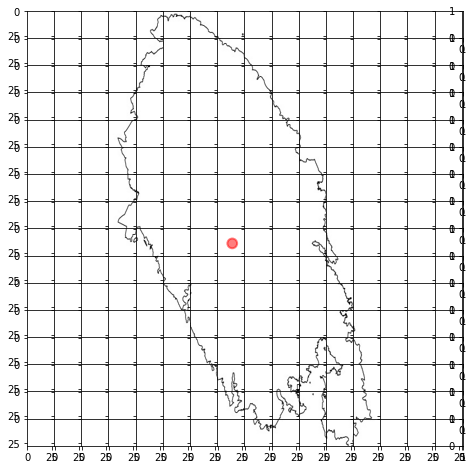

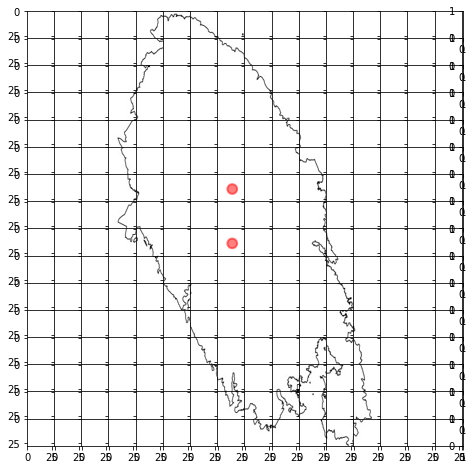

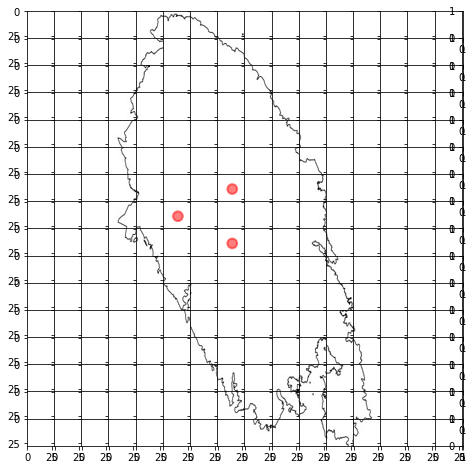

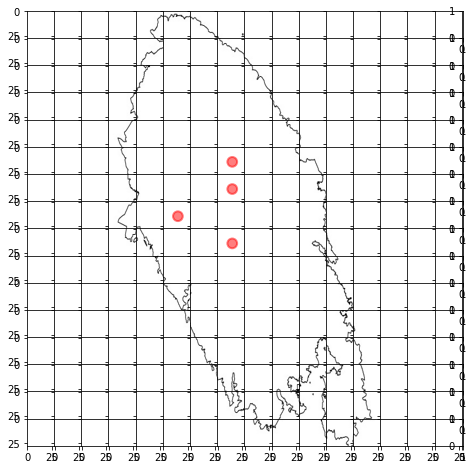

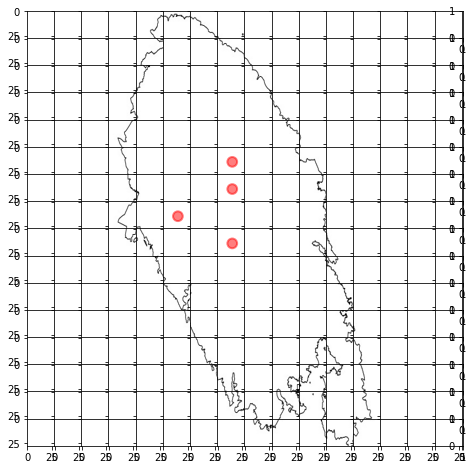

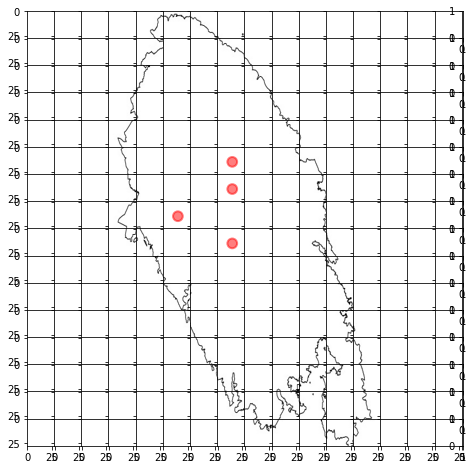

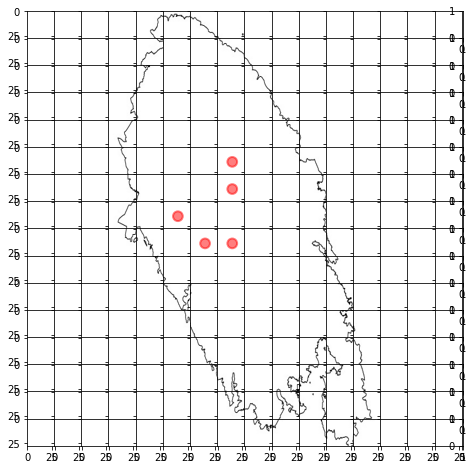

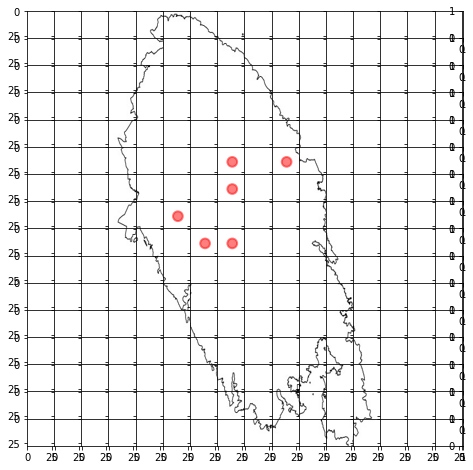

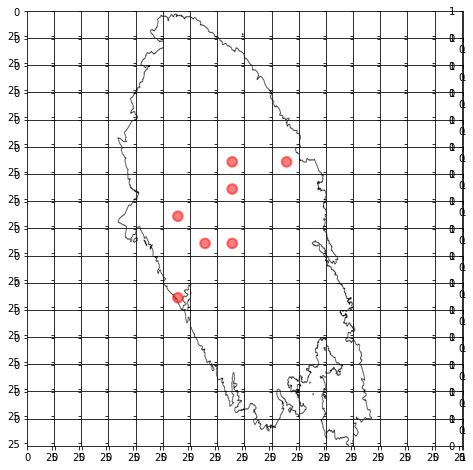

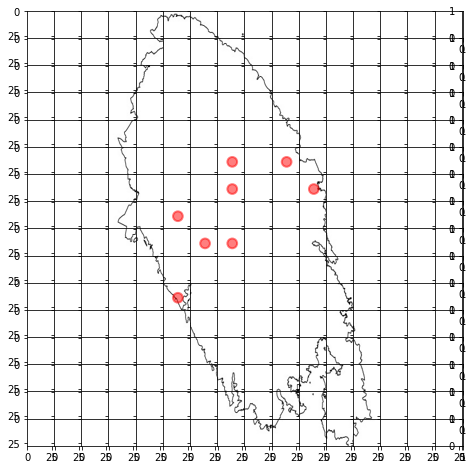

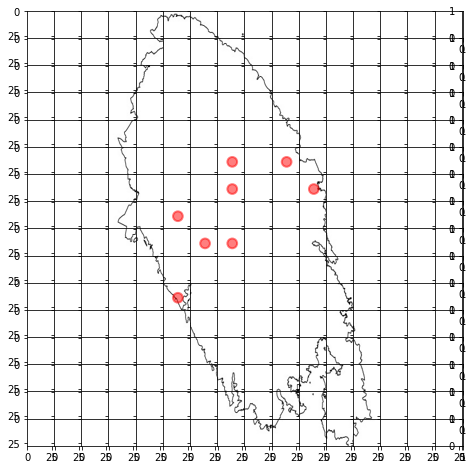

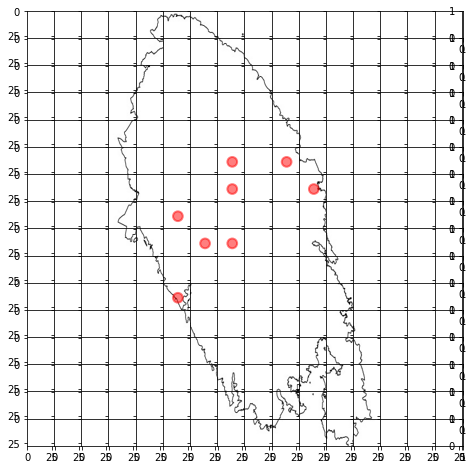

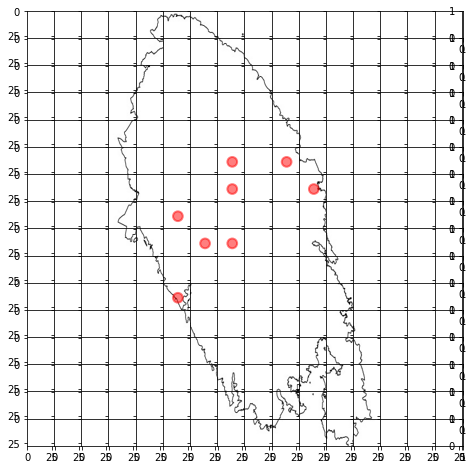

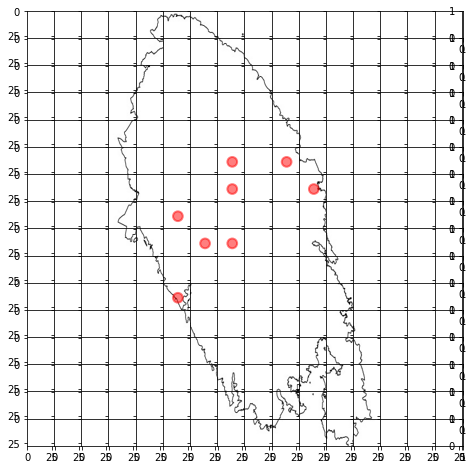

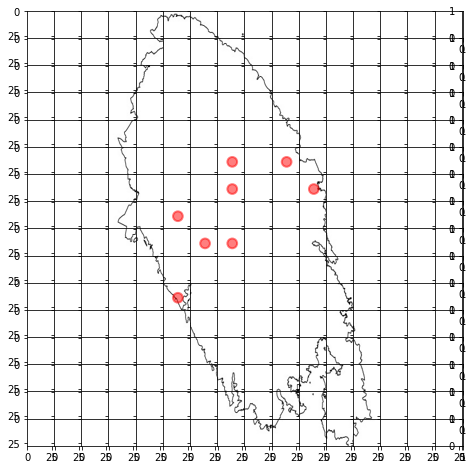

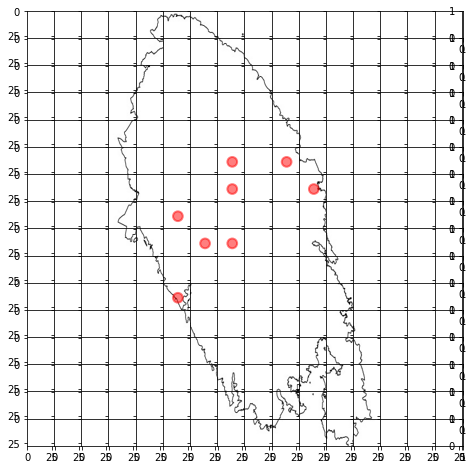

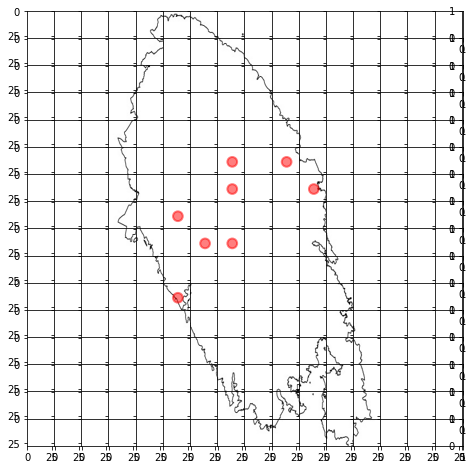

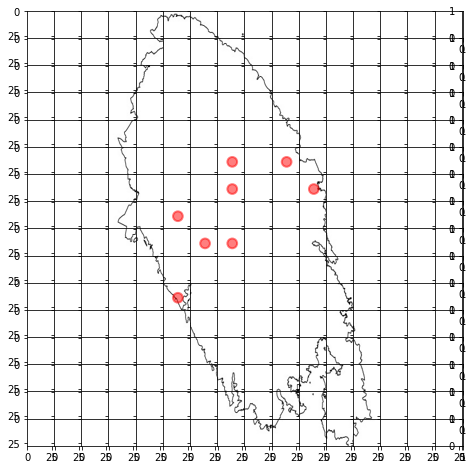

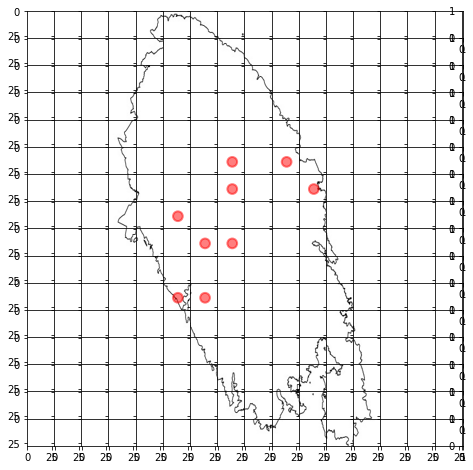

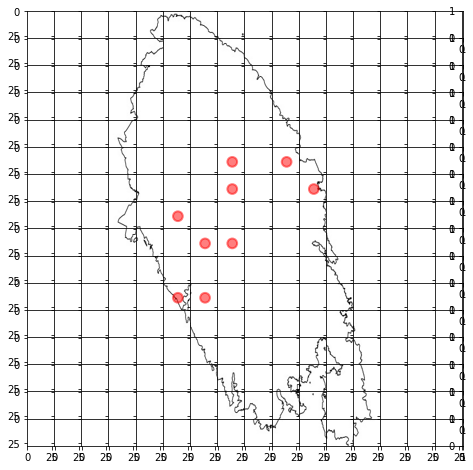

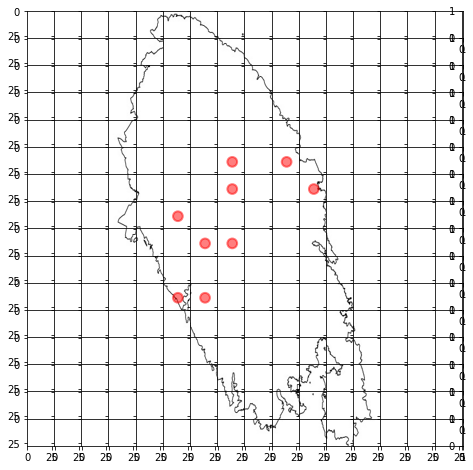

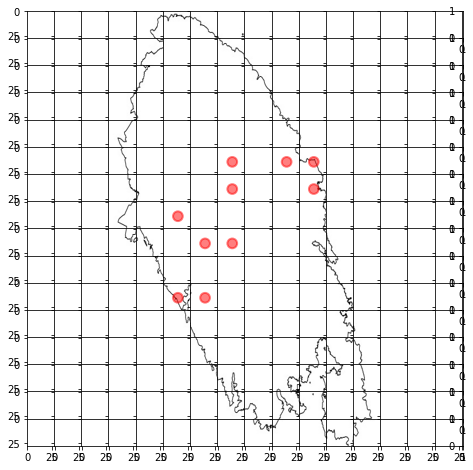

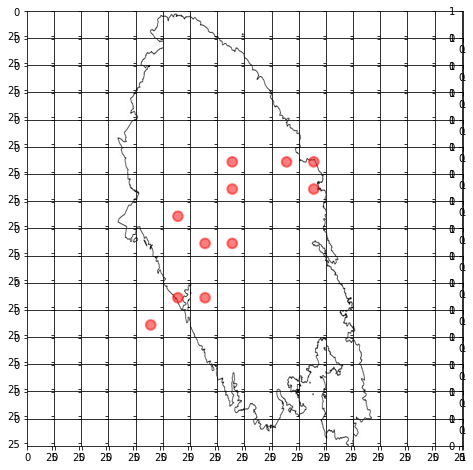

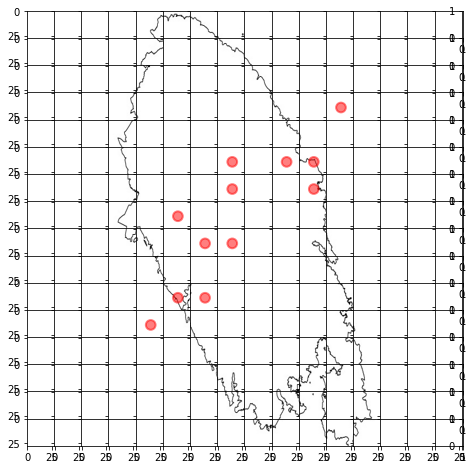

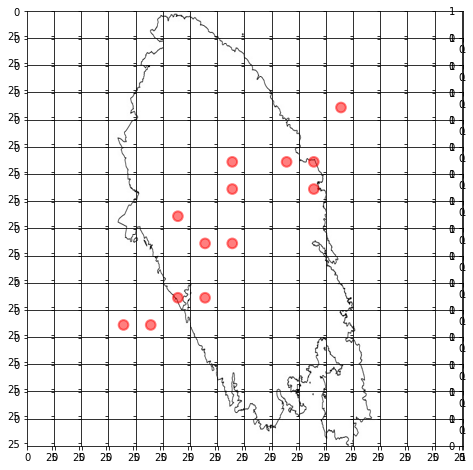

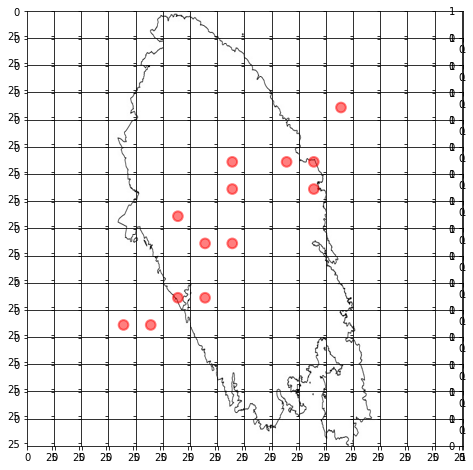

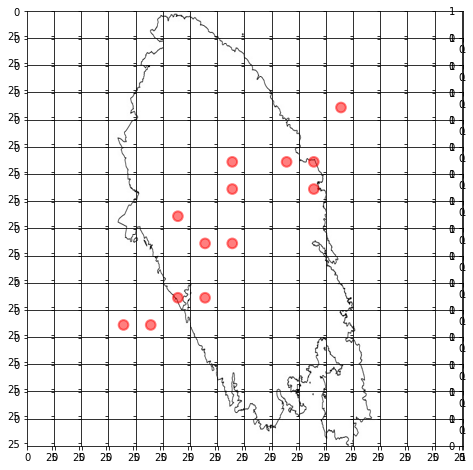

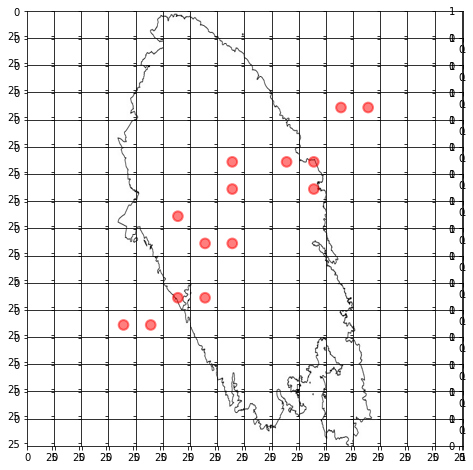

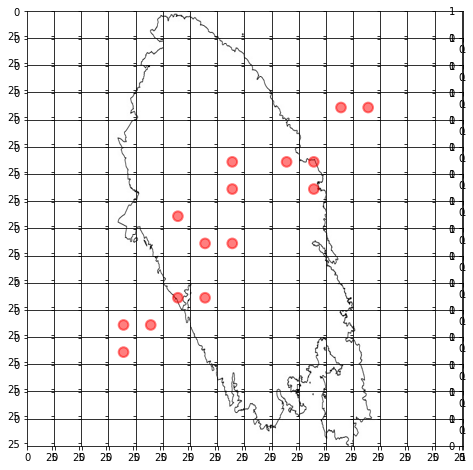

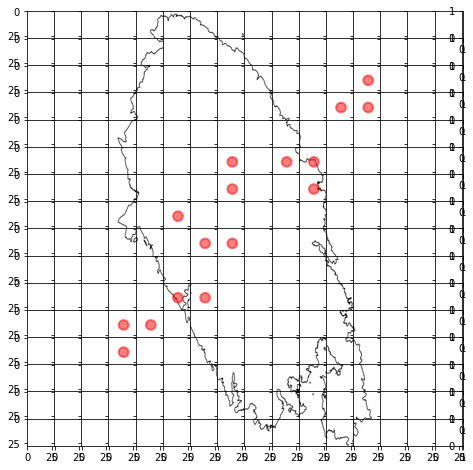

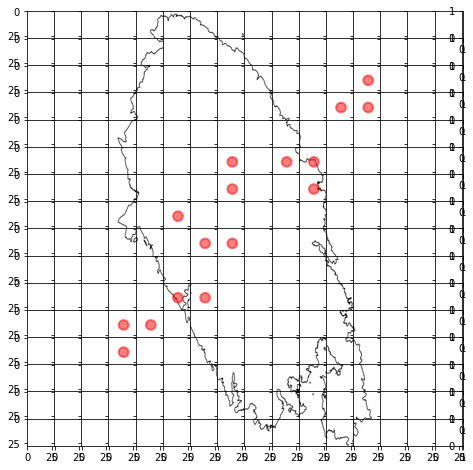

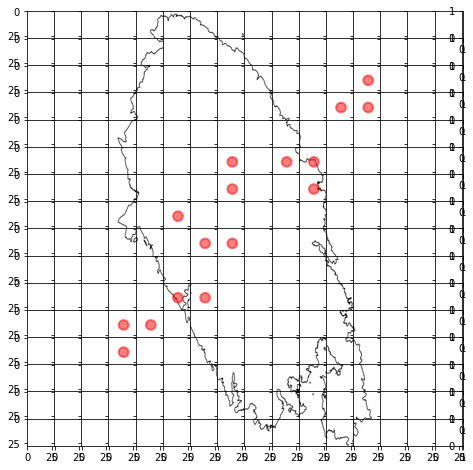

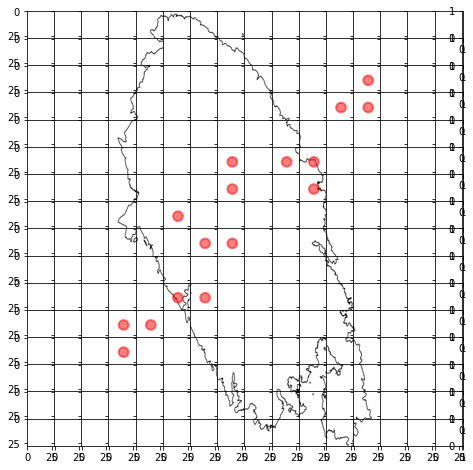

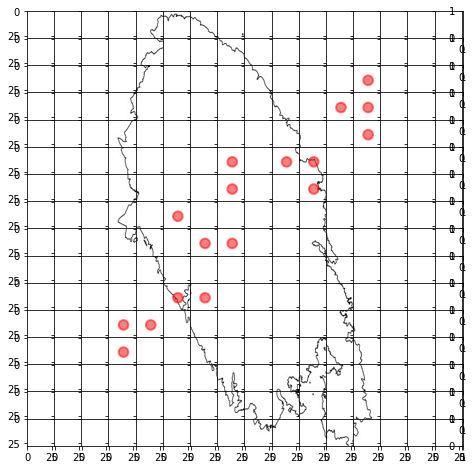

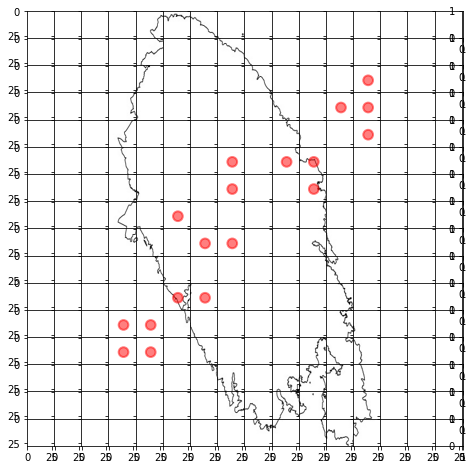

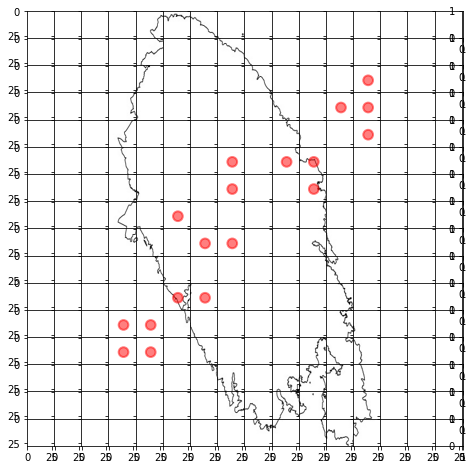

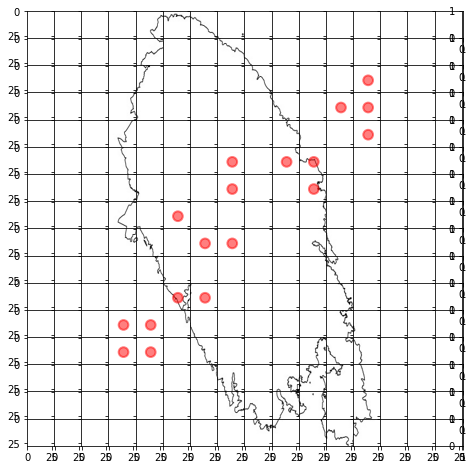

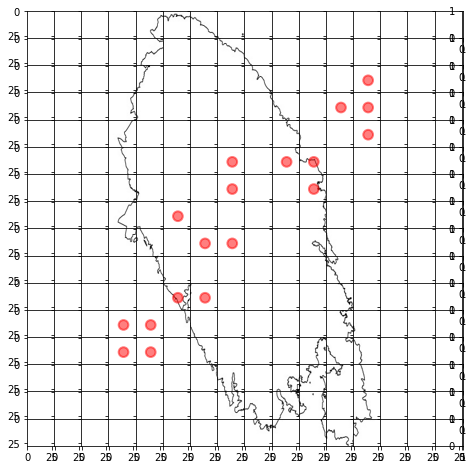

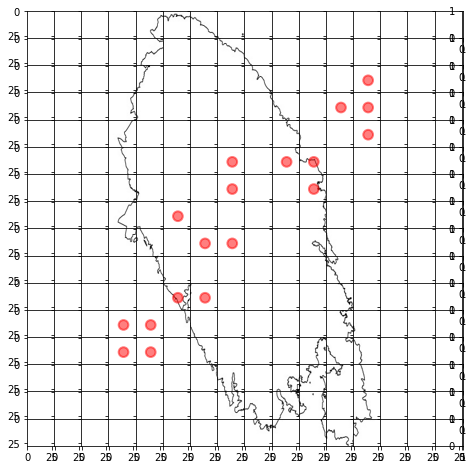

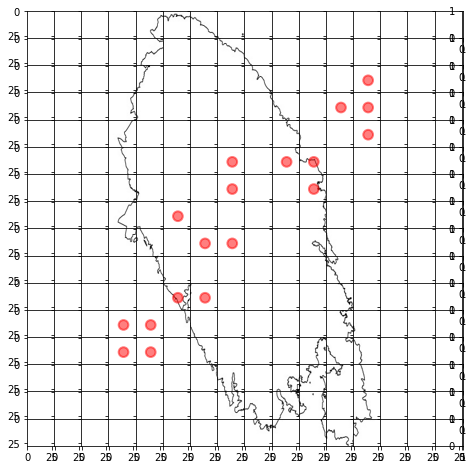

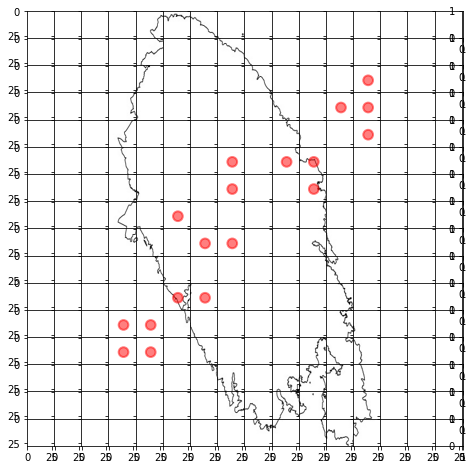

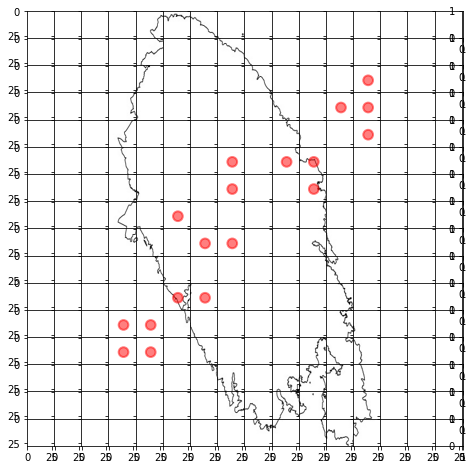

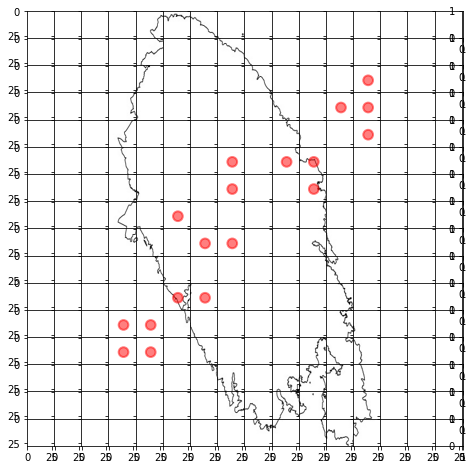

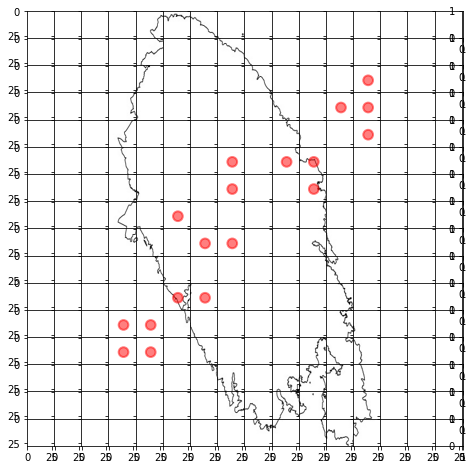

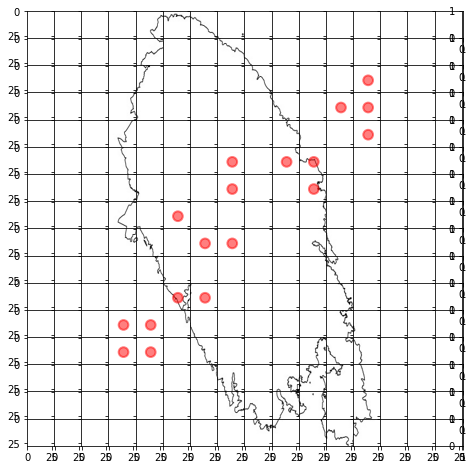

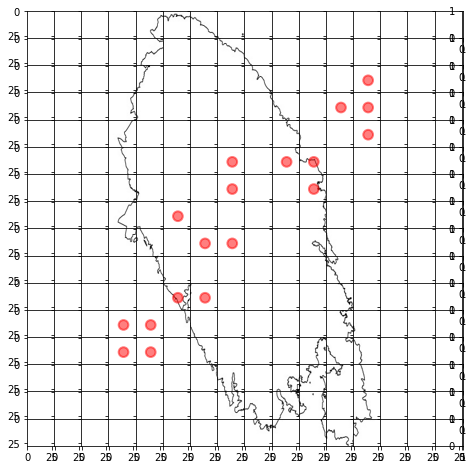

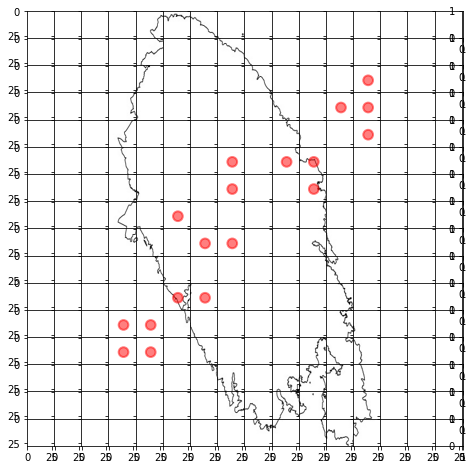

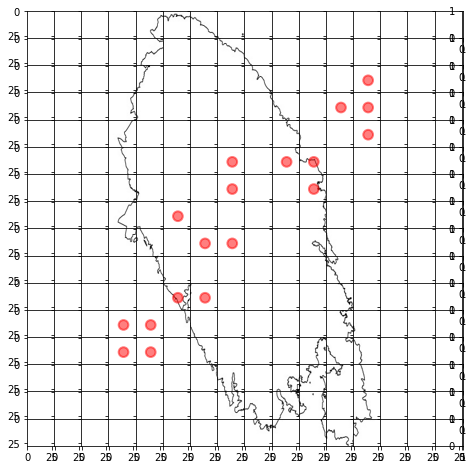

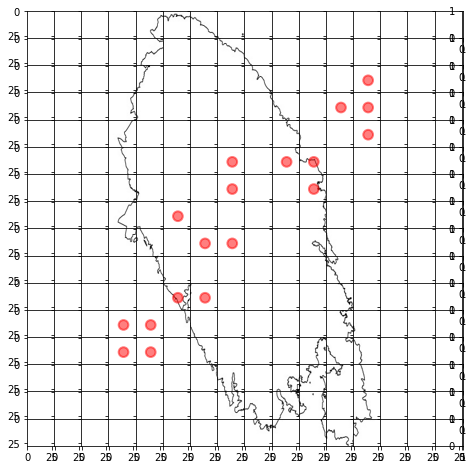

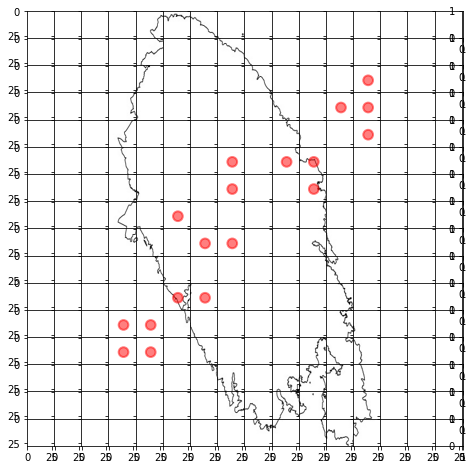

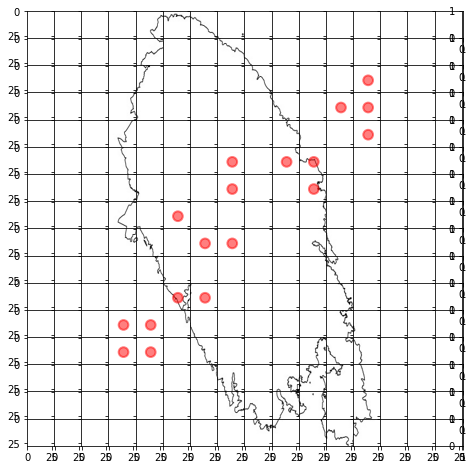

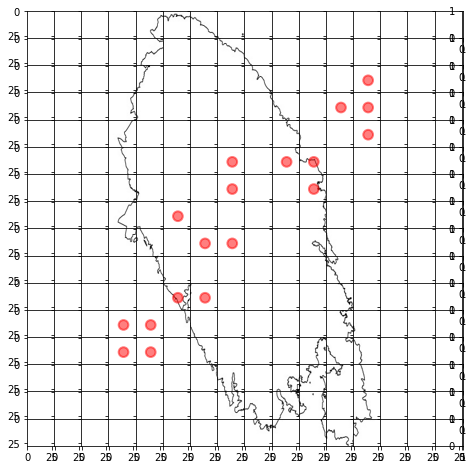

In [ ]:
start_modelling()

In [ ]:
pip install imageio

In [ ]:
import imageio
list_files = os.listdir(output_path)
list_files.sort()
images = []
for filename in list_files:
    images.append(imageio.imread(output_path + filename))
imageio.mimsave(output_path + 'final_output_progression.gif', images)